modèle n'est pas bon, ce peut être la faute de quelque fonction comme sampled_softmax_loss() dans model.
De toute façon, le modèle est plus lourd que ce lui de Torch
Tester pour:
hidden_size = 40, layer =3, sample_size = 200 accuracy = 17%
hidden_size = 40, layer =3, sample_size = DEC_VOCAB-1, accuracy = 27%

In [1]:
from __future__ import division
from __future__ import print_function

import argparse
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import random
import sys
import time
import math

import numpy as np
import tensorflow as tf

from model_70_1 import ChatBotModel
import config_tf as config
import data

import matplotlib.pyplot as plt


def run_step(sess, model, encoder_inputs, decoder_inputs,
             decoder_masks, bucket_id, forward_only):
    encoder_size, decoder_size = config.BUCKETS[bucket_id]
    input_feed = {}
    for step in range(encoder_size):
        input_feed[model.encoder_inputs[step].name] = encoder_inputs[step]
    for step in range(decoder_size):
        input_feed[model.decoder_inputs[step].name] = decoder_inputs[step]
        input_feed[model.decoder_masks[step].name] = decoder_masks[step]
    
    last_target = model.decoder_inputs[decoder_size].name
    input_feed[last_target] = np.zeros([model.batch_size], dtype=np.int32)
    if not forward_only:
        output_feed = [model.train_ops[bucket_id],  # update op that does SGD.
                       model.gradient_norms[bucket_id],  # gradient norm.
                       model.losses[bucket_id]]  # loss for this batch.
    else:
        output_feed = [model.losses[bucket_id]]  # loss for this batch.
        for step in range(decoder_size):  # output logits.
            output_feed.append(model.outputs[bucket_id][step])
    outputs = sess.run(output_feed, input_feed)
    if not forward_only:
        return outputs[1], outputs[2], None  # Gradient norm, loss, no outputs.
    else:
        return None, outputs[0], outputs[1:]  # No gradient norm, loss, outputs.

def _get_data(train=True):
    
    #enc_vocab, dec_vocab, inv_enc_vocab, inv_dec_vocab = build_vocab()
    if train:
          DATA = data.load_data('train_question.txt', 'train_answer.txt', inv_enc_vocab, inv_dec_vocab)
    else:
          DATA = data.load_data('test_question.txt', 'test_answer.txt', inv_enc_vocab, inv_dec_vocab)                              
    return  DATA

def _get_skip_step(n_iters):
    """ How many steps should the model train before it saves all the weights. """

    return int(n_iters/10)

def _check_restore_parameters(sess, saver):
    """ Restore the previously trained parameters if there are any. """
    ckpt = tf.train.get_checkpoint_state(os.path.dirname(config.CPT_PATH_70_1 + '/checkpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        print("Loading parameters for the Chatbot")
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        print("Initializing fresh parameters for the Chatbot")



def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(n_iters, lr = config.LR):
    """ Train the bot """
    data_buckets = training_data
    tf.reset_default_graph() 
    model = ChatBotModel(False, config.BATCH_SIZE, lr = lr)
    model.build_graph()

    saver = tf.train.Saver()

    with tf.Session() as sess:
        print('Running session')
        sess.run(tf.global_variables_initializer())
        _check_restore_parameters(sess, saver)

        iteration = model.global_step.eval()
        total_loss = 0
        step =0
        loss_print = []
        bucket_id = 0
        start = time.time()
        while step < n_iters:
            step+=1
            skip_step = _get_skip_step(n_iters)
            encoder_inputs, decoder_inputs, decoder_masks = data.get_batch(data_buckets, 
                                                                           bucket_id,
                                                                           batch_size=config.BATCH_SIZE)
            
            _, step_loss, _ = run_step(sess, model, encoder_inputs, 
                                       decoder_inputs, decoder_masks, bucket_id, False)
            total_loss += step_loss
            iteration += 1
            if iteration % skip_step == 0:  
                print_loss_avg = total_loss / skip_step
                total_loss = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, step / n_iters),
                                         iteration, step / n_iters * 100, print_loss_avg))
                total_loss = 0
                loss_print.append(step_loss)
        saver.save(sess, os.path.join(config.CPT_PATH_70_1, 'chatbot'), global_step=model.global_step)
        sys.stdout.flush()
        plt.plot(loss_print)
        plt.show()

def _get_user_input():
    t = input('Vous:  ')
    return t

def _construct_reponse(output_logits, dec_vocab):
    outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
    if config.EOS_ID in outputs:
        outputs = outputs[:outputs.index(config.EOS_ID)]

    return " ".join([tf.compat.as_str(dec_vocab[output]) for output in outputs])

def chat():
    _, enc_vocab = data.load_vocab(os.path.join(config.PROCESSED_PATH, 'encoder_vocab.txt'))
    inv_dec_vocab, _= data.load_vocab(os.path.join(config.PROCESSED_PATH, 'decoder_vocab.txt'))
    tf.reset_default_graph() 
    model = ChatBotModel(True, batch_size=1)
    model.build_graph()

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        _check_restore_parameters(sess, saver)
        output_file = open(os.path.join(config.PROCESSED_PATH, config.OUTPUT_FILE), 'a+')
        max_length = config.BUCKETS[-1][0]
        print('Bonjour, dites moi ce que vous voulez: ')
        while True:
            line = _get_user_input()
            if len(line) > 0 and line[-1] == '\n':
                line = line[:-1]
            if line == '':
                break
            output_file.write('VOUS ++++ ' + line + '\n')
            token_ids = data.sentence2id(enc_vocab, str(line))
            if (len(token_ids) > max_length):
                print('La longueur maximale est:', max_length)
                continue
            bucket_id = _find_right_bucket(len(token_ids))
            encoder_inputs, decoder_inputs, decoder_masks = data.get_batch([(token_ids, [])], 
                                                                            bucket_id,
                                                                            batch_size=1)
            _, _, output_logits = run_step(sess, model, encoder_inputs, decoder_inputs,
                                           decoder_masks, bucket_id, True)
            response = _construct_reponse(output_logits, dec_vocab)
            
            print('Bot de AVICEN:  ', response)
            output_file.write('BOT ++++ ' + response + '\n')
        output_file.write('=============================================\n')
        output_file.close()
        
def evaluate_randomly(n_iters=300, test=True):
    if not test:
        tf.reset_default_graph() 
        model = ChatBotModel(True, batch_size=1)
        model.build_graph()
        saver = tf.train.Saver()
        list_print_random = random.sample(range(n_iters), 20)
        total_loss = 0
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            _check_restore_parameters(sess, saver)
            for i in range(n_iters):
                random_index = random.choice(range(len(training_data)))
                bucket_id = 0  
                question = training_data[random_index][0]
                answer = training_data[random_index][1]
                encoder_inputs, decoder_inputs, decoder_masks = \
                    data.get_batch([(question, [])], \
                    bucket_id, batch_size=1)
                _, _, output_logits = run_step(sess, model, encoder_inputs, decoder_inputs,
                                           decoder_masks, bucket_id, True)
                reponse = _construct_reponse(output_logits, dec_vocab)
                bonne_reponse = " ".join([str(dec_vocab[id]) for id in answer])
                question = " ".join([str(enc_vocab[id]) for id in question])
                loss = _evaluate_by_right_word(reponse, bonne_reponse)
                total_loss +=loss
                if i in list_print_random:
                    print('--------------------------------------------------')
                    print('Question:  ',  question)
                    print('Bot     :  ', reponse)
                    print('Réponse: {}  ACCURACY {}'.format(bonne_reponse, 1-loss))
        print('Test on {} sentences in train set with accuracy {}'.format(n_iters,1- total_loss/n_iters))
    else:
        tf.reset_default_graph() 
        model = ChatBotModel(True, batch_size=1)
        model.build_graph()
        saver = tf.train.Saver()
        total_loss = 0
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            _check_restore_parameters(sess, saver)
            n_iters = len(test_data)
            print_random_index = random.sample(range(n_iters), 20)
            bucket_id = 0
            for i in range(n_iters):
                question = test_data[i][0]
                answer = test_data[i][1]
                encoder_inputs, decoder_inputs, decoder_masks = data.get_batch([(question, [])], 
                                                                            bucket_id,
                                                                            batch_size=1)
                _, _, output_logits = run_step(sess, model, encoder_inputs, decoder_inputs,
                                           decoder_masks, bucket_id, True)
                reponse = _construct_reponse(output_logits, dec_vocab)
                bonne_reponse = " ".join([str(dec_vocab[id]) for id in answer[1:-1]])
                loss = _evaluate_by_right_word(reponse, bonne_reponse)
                total_loss +=loss
                if i in print_random_index:
                    question = " ".join([str(enc_vocab[id]) for id in question])
                    print('Question: ', question)
                    print('Reponse: ', reponse)
                    print('Bonne Reponse: {}. ACCURACY {:.1f} '.format(bonne_reponse,1-loss))
                    print('-'*50)
        print('Test on {} sentences'.format(n_iters))
        print('Accuracy by percent of true words {}'.format(1-total_loss/n_iters))
        #return loss/n_iters

def _evaluate_by_right_word(reponse, bonne_reponse):
    reponse = reponse.split()
    bonne_reponse = bonne_reponse.split()
    min_length = min(len(reponse), len(bonne_reponse))
    max_length = max(len(reponse), len(bonne_reponse))
    error = max_length-min_length
    for i in range(min_length):
        if reponse[i] != bonne_reponse[i]:
            error +=1
    return error/max_length

if __name__ =='__main__':
    try:
        training_data
    except NameError:
        enc_vocab, dec_vocab, inv_enc_vocab, inv_dec_vocab = data.build_vocab()
        training_data = _get_data(True)
        test_data = _get_data(False)
    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


load 567 sentences from data
load 141 sentences from data


Initialize new model
Create placeholders
Create inference
Creating loss... 
It might take a couple of minutes depending on how many buckets you have.
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Time: 4.4050233364105225
Create optimizer... 
It might take a couple of minutes depending on how many data  you have.
Running session
Initializing fresh parameters for the Chatbot
33m 3s (- 297m 31s) (5000 10%) 0.9649
65m 37s (- 262m 28s) (10000 20%) 0.0127
98m 18s (- 229m 22s) (15000 30%) 0.0069
130m 46s (- 196m 10s) (20000 40%) 0.0055
164m 31s (- 164m 31s) (25000 50%) 0.0049
238m 40s (- 159m 6s) (30000 60%) 0.0044
290m 27s (- 124m 29s) (35000 70%) 0.0044
330m 2s (- 82m 30s) (40000 80%) 0.0041
392m 24s (- 43m 36s) (45000 90%) 0.0041
426m 29s (- 0m 0s) (50000 100%) 0.0039


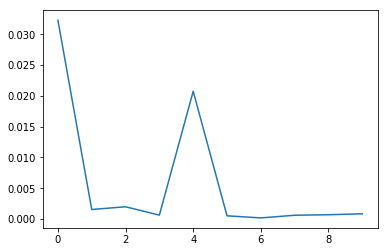

In [2]:
train(50000)